In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# specific libraries for RNN
# keras is a high layer build on Tensorflow layer to stay in high level/easy implementation
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
from keras.models import model_from_json
import sys
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = os.path.join('.', 'data')

In [3]:
data_paths = {'train': os.path.join(DATA_DIR, 'train.csv'), 
              'metadata':  os.path.join(DATA_DIR, 'metadata.csv'),
              'weather':  os.path.join(DATA_DIR, 'weather.csv'),
              'holidays':  os.path.join(DATA_DIR, 'holidays.csv'),
              'submission_format':  os.path.join(DATA_DIR, 'submission_format.csv')}

In [4]:
site_one_combined = pd.read_parquet("./data/site_one.parquet")
site_one_combined = site_one_combined[site_one_combined.Values.notnull()]

In [5]:
site_two_combined = pd.read_parquet("./data/site_two.parquet")
site_two_combined = site_two_combined[site_two_combined.Values.notnull()]

In [6]:
site_three_combined = pd.read_parquet("./data/site_three.parquet")
site_three_combined = site_three_combined[site_three_combined.Values.notnull()]

In [7]:
import time
from sklearn import preprocessing

In [8]:
site_one_combined.head()

,obs_id,meter_id,Timestamp,Values,Date,DayOfWeek,site_id,meter_description,units,surface,...,Median_928,Values_930,Median_930,Values_935,Median_935,Values_938,Median_938,Values_234_203,Median_234_203,Temperature
38,17244,234_203,2013-11-03 19:00:00,11.636,2013-11-03,Sunday,234_203,virtual main,kWh,5750.0,...,NaN,0.0,0.0,0.0,0.1,11.106,11.371000,11.106,11.371000,16.1
39,17254,234_203,2013-11-03 19:30:00,11.106,2013-11-03,Sunday,234_203,virtual main,kWh,5750.0,...,NaN,0.0,0.0,0.0,0.1,10.957,11.233000,10.957,11.233000,15.0
40,17241,234_203,2013-11-03 20:00:00,10.957,2013-11-03,Sunday,234_203,virtual main,kWh,5750.0,...,NaN,0.0,0.0,1.0,0.2,11.157,11.214000,11.157,11.214000,15.0
41,17243,234_203,2013-11-03 20:30:00,11.157,2013-11-03,Sunday,234_203,virtual main,kWh,5750.0,...,NaN,0.0,0.0,0.0,0.2,12.196,11.410400,12.196,11.410400,14.0
42,17240,234_203,2013-11-03 21:00:00,12.196,2013-11-03,Sunday,234_203,virtual main,kWh,5750.0,...,NaN,0.0,0.0,0.0,0.2,11.979,11.505167,11.979,11.505167,14.0


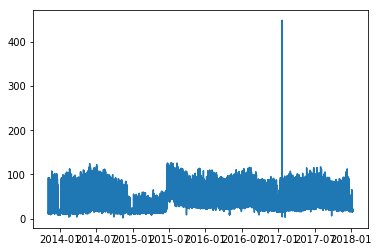

In [22]:
plt.plot(site_one_combined['Timestamp'],site_one_combined['Values'])

In [26]:
site_one_combined[site_one_combined.Values>200]

,obs_id,meter_id,Timestamp,Values,Date,DayOfWeek,site_id,meter_description,units,surface,...,Median_928,Values_930,Median_930,Values_935,Median_935,Values_938,Median_938,Values_234_203,Median_234_203,Temperature
56325,70450,234_203,2017-01-19 10:30:00,448.788,2017-01-19,Thursday,234_203,virtual main,kWh,5750.0,...,4.460321e-15,20.0,7.7,0.0,0.0,184.629,62.6441,448.788,150.3311,18.0
56326,70476,234_203,2017-01-19 11:00:00,448.788,2017-01-19,Thursday,234_203,virtual main,kWh,5750.0,...,4.460321e-15,20.0,9.4,0.0,0.0,184.629,78.4109,448.788,189.0680,18.0
56327,70468,234_203,2017-01-19 11:30:00,448.788,2017-01-19,Thursday,234_203,virtual main,kWh,5750.0,...,4.460321e-15,0.0,8.9,0.0,0.0,9.333,76.1855,23.512,184.4281,18.0


In [81]:
x_site_one_columns = [x for x in site_one_combined.select_dtypes(include='object') if x not in ['obs_id','meter_id','site_id']]
x_train_site_one = pd.get_dummies(site_one_combined, columns = x_site_one_columns).ffill().bfill()
x_train_site_one.TimestampSeconds = x_train_site_one.Timestamp.apply (lambda x: time.mktime(x.timetuple()))
#features = [x for x in x_train_site_one.columns if x not in ['Timestamp','meter_id','Date']]
#x_train_site_one.loc[(x_train_site_one.obs_id==70476) & (x_train_site_one.meter_id=='234_203'),'Values'] = np.nan
#x_train_site_one.loc[(x_train_site_one.obs_id==70468) & (x_train_site_one.meter_id=='234_203'),'Values'] = np.nan
features_one = x_train_site_one[['Values','surface', 'isHoliday', 'isHolidayTomorrow',
       'isHolidayYesterday', 'Temperature', 'DayOfWeek_Friday', 'DayOfWeek_Monday',
       'DayOfWeek_Saturday', 'DayOfWeek_Sunday', 'DayOfWeek_Thursday',
       'DayOfWeek_Tuesday', 'DayOfWeek_Wednesday', 'activity_office']].columns
scaler_one = preprocessing.RobustScaler(quantile_range=(25, 75))
data_one  = pd.DataFrame(scaler_one.fit_transform(x_train_site_one[features_one]))
prediction_time = 1
testdatasize = 25000
unroll_length = 100
testdatacut = testdatasize + unroll_length+1

In [82]:
x_train = data_one.as_matrix()
y_train = data_one[0].as_matrix()

In [83]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
y_train = y_train[-x_train.shape[0]:]

# see the shape
print("x_train", x_train.shape)
print("y_train", y_train.shape)

x_train (72870, 100, 14)
y_train (72870,)


In [84]:
# Build the model
model_one = Sequential()

model_one.add(LSTM(
    input_dim=x_train.shape[-1],
    output_dim=50,
    return_sequences=True))
model_one.add(Dropout(0.2))

model_one.add(LSTM(
    100,
    return_sequences=False))
model_one.add(Dropout(0.2))

model_one.add(Dense(
    units=1))
model_one.add(Activation('linear'))

start = time.time()
model_one.compile(loss='mse', optimizer='rmsprop')
print('compilation time : {}'.format(time.time() - start))

compilation time : 0.04880046844482422


In [172]:
model_one.fit(
    x_train,
    y_train,
    batch_size=3028,
    nb_epoch=350,
    shuffle=True,
    validation_split=0.1)

Train on 65583 samples, validate on 7287 samples
Epoch 1/350
65583/65583 [==============================] - 171s 3ms/step - loss: 0.0161 - val_loss: 0.0078
Epoch 2/350
65583/65583 [==============================] - 162s 2ms/step - loss: 0.0154 - val_loss: 0.0067
Epoch 3/350
65583/65583 [==============================] - 160s 2ms/step - loss: 0.0152 - val_loss: 0.0073
Epoch 4/350
65583/65583 [==============================] - 162s 2ms/step - loss: 0.0151 - val_loss: 0.0083
Epoch 5/350
65583/65583 [==============================] - 167s 3ms/step - loss: 0.0148 - val_loss: 0.0084
Epoch 6/350
65583/65583 [==============================] - 161s 2ms/step - loss: 0.0144 - val_loss: 0.0069
Epoch 7/350
65583/65583 [==============================] - 161s 2ms/step - loss: 0.0140 - val_loss: 0.0085
Epoch 8/350
65583/65583 [==============================] - 160s 2ms/step - loss: 0.0138 - val_loss: 0.0081
Epoch 9/350
65583/65583 [==============================] - 160s 2ms/step - loss: 0.0138 - val_l

65583/65583 [==============================] - 160s 2ms/step - loss: 0.0096 - val_loss: 0.0062
Epoch 77/350
65583/65583 [==============================] - 160s 2ms/step - loss: 0.0095 - val_loss: 0.0058
Epoch 78/350
65583/65583 [==============================] - 160s 2ms/step - loss: 0.0094 - val_loss: 0.0061
Epoch 79/350
65583/65583 [==============================] - 165s 3ms/step - loss: 0.0098 - val_loss: 0.0058
Epoch 80/350
65583/65583 [==============================] - 163s 2ms/step - loss: 0.0094 - val_loss: 0.0061
Epoch 81/350
65583/65583 [==============================] - 160s 2ms/step - loss: 0.0095 - val_loss: 0.0071
Epoch 82/350
65583/65583 [==============================] - 161s 2ms/step - loss: 0.0095 - val_loss: 0.0062
Epoch 83/350
65583/65583 [==============================] - 161s 2ms/step - loss: 0.0095 - val_loss: 0.0052
Epoch 84/350
65583/65583 [==============================] - 163s 2ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 85/350
65583/65583 [===============

65583/65583 [==============================] - 161s 2ms/step - loss: 0.0086 - val_loss: 0.0055
Epoch 152/350
65583/65583 [==============================] - 161s 2ms/step - loss: 0.0084 - val_loss: 0.0056
Epoch 153/350
65583/65583 [==============================] - 164s 2ms/step - loss: 0.0085 - val_loss: 0.0051
Epoch 154/350
65583/65583 [==============================] - 168s 3ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 155/350
65583/65583 [==============================] - 169s 3ms/step - loss: 0.0086 - val_loss: 0.0056
Epoch 156/350
65583/65583 [==============================] - 167s 3ms/step - loss: 0.0084 - val_loss: 0.0051
Epoch 157/350
65583/65583 [==============================] - 166s 3ms/step - loss: 0.0084 - val_loss: 0.0055
Epoch 158/350
65583/65583 [==============================] - 168s 3ms/step - loss: 0.0084 - val_loss: 0.0060
Epoch 159/350
65583/65583 [==============================] - 163s 2ms/step - loss: 0.0085 - val_loss: 0.0062
Epoch 160/350
65583/65583 [======

65583/65583 [==============================] - 160s 2ms/step - loss: 0.0080 - val_loss: 0.0058
Epoch 227/350
65583/65583 [==============================] - 153s 2ms/step - loss: 0.0080 - val_loss: 0.0050
Epoch 228/350
65583/65583 [==============================] - 151s 2ms/step - loss: 0.0081 - val_loss: 0.0047
Epoch 229/350
65583/65583 [==============================] - 154s 2ms/step - loss: 0.0079 - val_loss: 0.0049
Epoch 230/350
65583/65583 [==============================] - 157s 2ms/step - loss: 0.0080 - val_loss: 0.0056
Epoch 231/350
65583/65583 [==============================] - 168s 3ms/step - loss: 0.0079 - val_loss: 0.0054
Epoch 232/350
65583/65583 [==============================] - 168s 3ms/step - loss: 0.0080 - val_loss: 0.0051
Epoch 233/350
65583/65583 [==============================] - 170s 3ms/step - loss: 0.0079 - val_loss: 0.0047
Epoch 234/350
65583/65583 [==============================] - 163s 2ms/step - loss: 0.0080 - val_loss: 0.0051
Epoch 235/350
65583/65583 [======

KeyboardInterrupt: 

In [ ]:

# serialize model to JSON
model_json = model_one.to_json()
with open("model_one.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_one.save_weights("model2.h5")
print("Saved model to disk")


In [ ]:
# load json and create model
"""
json_file = open('model_one.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
"""

In [103]:
loaded_model = model_one
diff=[]
ratio=[]
p = loaded_model.predict(x_train)
# predictions = lstm.predict_sequences_multiple(loaded_model, x_test, 50, 50)
for u in range(len(y_train)):
    pr = p[u][0]
    ratio.append((y_train[u]/pr)-1)
    diff.append((y_train[u]- pr))

In [168]:
# select the most distant prediction/reality data points as anomalies
outliers_fraction = 0.001
diff = pd.Series(diff)
number_of_outliers = int(outliers_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()
# data with anomaly label (test data part)
test = (diff >= threshold).astype(int)
x_train_site_one['isabnormal'] = test
print(x_train_site_one['isabnormal'].value_counts())

0.0    72569
1.0       71
Name: isabnormal, dtype: int64


In [169]:
print(threshold)

0.553359050389


In [170]:
print(threshold)

0.553359050389


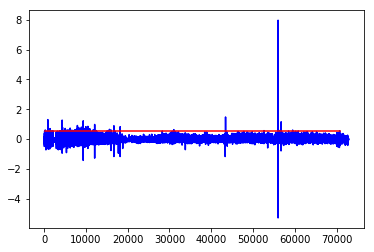

In [171]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()
a = x_train_site_one.loc[x_train_site_one['isabnormal'] == 1, ['Timestamp', 'Values']] #
a['Values'] = threshold
ax.plot(pd.Series(diff), color='blue')
ax.plot(a['Values'], color='red')
#plt.axis([-100, 100, 3,30])
plt.show()

In [210]:
site_one_pred = pd.DataFrame(data=y_pred_site_one, columns=['isabnormal'], index=x_train_site_one.index)
site_one_pred = pd.merge(site_one_pred, x_train_site_one, left_index=True,right_index=True)[['obs_id','meter_id','Timestamp','isabnormal']]

In [29]:
site_one_pred[(site_one_pred.obs_id=='70450') & (site_one_pred.meter_id=='234_203')]
#70450	234_203
#70476	234_203
#70468	234_203

NameError: name 'site_one_pred' is not defined

In [211]:
x_site_two_columns = [x for x in site_two_combined.select_dtypes(include='object') if x not in ['obs_id','meter_id','site_id']]
x_train_site_two = pd.get_dummies(site_two_combined, columns = x_site_two_columns).ffill().bfill()
x_train_site_two.TimestampSeconds = x_train_site_two.Timestamp.apply (lambda x: time.mktime(x.timetuple()))
features = [x for x in x_train_site_two.columns if x not in ['Timestamp','Date']]
#clf_site_two = IsolationForest()
clf_site_two = LocalOutlierFactor()
y_pred_site_two = clf_site_two.fit_predict(x_train_site_two[features])
#y_pred_site_two = clf_site_two.predict(x_train_site_two[features])

In [212]:
site_two_pred = pd.DataFrame(data=y_pred_site_two, columns=['isabnormal'], index=x_train_site_two.index)
site_two_pred = pd.merge(site_two_pred, x_train_site_two, left_index=True,right_index=True)[['obs_id','meter_id','Timestamp','isabnormal']]

In [214]:
x_site_three_columns = [x for x in site_three_combined.select_dtypes(include='object') if x not in ['obs_id','meter_id','site_id']]
x_train_site_three = pd.get_dummies(site_three_combined, columns = x_site_three_columns).ffill().bfill()
x_train_site_three.TimestampSeconds = x_train_site_three.Timestamp.apply (lambda x: time.mktime(x.timetuple()))
features = [x for x in x_train_site_three.columns if x not in ['Timestamp','Date']]
#clf_site_three = IsolationForest()
clf_site_three = LocalOutlierFactor()
y_pred_site_three= clf_site_three.fit_predict(x_train_site_three[features])
#y_pred_site_three = clf_site_three.predict(x_train_site_three[features])

In [215]:
site_three_pred = pd.DataFrame(data=y_pred_site_three, columns=['isabnormal'], index=x_train_site_three.index)
site_three_pred = pd.merge(site_three_pred, x_train_site_three, left_index=True,right_index=True)[['obs_id','meter_id','Timestamp','isabnormal']]

In [216]:
submission_raw = pd.concat([site_one_pred, site_two_pred, site_three_pred])
submission_raw = submission_raw.groupby(['meter_id','Timestamp']).min().reset_index()

In [217]:
submission_format = pd.read_csv(data_paths['submission_format'])
submission_format['Timestamp'] = pd.to_datetime(submission_format['Timestamp'])

In [218]:
len(submission_raw)

402635

In [219]:
len(submission_format)

402635

In [220]:
submission = pd.merge(submission_format,submission_raw, left_on=['meter_id','Timestamp'],\
                      right_on=['meter_id','Timestamp'],
                      suffixes = ['','_raw'])

In [221]:
submission.head()

,obs_id,meter_id,Timestamp,is_abnormal,obs_id_raw,isabnormal
0,171227,234_203,2013-11-03 19:00:00,False,17244,1
1,177020,234_203,2013-11-03 19:30:00,False,17254,1
2,165375,234_203,2013-11-03 20:00:00,False,17241,1
3,207176,234_203,2013-11-03 20:30:00,False,17243,1
4,353253,234_203,2013-11-03 21:00:00,False,17240,1


In [222]:
submission.loc[submission.isabnormal==-1,'is_abnormal'] = True

In [223]:
submission.head()

,obs_id,meter_id,Timestamp,is_abnormal,obs_id_raw,isabnormal
0,171227,234_203,2013-11-03 19:00:00,False,17244,1
1,177020,234_203,2013-11-03 19:30:00,False,17254,1
2,165375,234_203,2013-11-03 20:00:00,False,17241,1
3,207176,234_203,2013-11-03 20:30:00,False,17243,1
4,353253,234_203,2013-11-03 21:00:00,False,17240,1


In [224]:
submission = submission[submission_format.columns]

In [225]:
submission.to_csv('submission.csv', index=False)

In [226]:
submission.head()

,obs_id,meter_id,Timestamp,is_abnormal
0,171227,234_203,2013-11-03 19:00:00,False
1,177020,234_203,2013-11-03 19:30:00,False
2,165375,234_203,2013-11-03 20:00:00,False
3,207176,234_203,2013-11-03 20:30:00,False
4,353253,234_203,2013-11-03 21:00:00,False
